## Importar

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
import optuna
import optuna.visualization as vis
from catboost import CatBoostClassifier

from Classes.dataframe_manager import DataFrameManager

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

c:\Users\LENOVO\anaconda3\envs\EnsamblesCatBoost\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Leer datos

In [2]:
# Asegurar que el directorio del proyecto esté en sys.path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Carga de dataframes utilizando la clase DataFrameManager
manager = DataFrameManager()

manager.load_multiple([
    'features_upsampled',
    'features_valid',
    'features_upsampled_ord',
    'features_valid_ord',
    'target_upsampled',
    'target_valid',
    'target_upsampled_ord',#
    'target_valid_ord'
])

DataFrame 'features_upsampled' cargado exitosamente en el administrador.
DataFrame 'features_valid' cargado exitosamente en el administrador.
DataFrame 'features_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'features_valid_ord' cargado exitosamente en el administrador.
DataFrame 'target_upsampled' cargado exitosamente en el administrador.
DataFrame 'target_valid' cargado exitosamente en el administrador.
DataFrame 'target_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'target_valid_ord' cargado exitosamente en el administrador.


In [4]:
# Asignar cada dataframe a una variable con su nombre para utilizarla en el notebook

features_upsampled = manager.get_dataframe('features_upsampled')
features_valid = manager.get_dataframe('features_valid')
features_upsampled_ord = manager.get_dataframe('features_upsampled_ord')
features_valid_ord = manager.get_dataframe('features_valid_ord')
target_upsampled = manager.get_dataframe('target_upsampled')
target_valid = manager.get_dataframe('target_valid')
target_upsampled_ord = manager.get_dataframe('target_upsampled_ord')
target_valid_ord = manager.get_dataframe('target_valid_ord')

In [5]:
# display(features_upsampled.head())

## Creación de modelos

### Regresión logística

#### Sin validación cruzada

In [6]:
model_lr = LogisticRegression(solver='liblinear', random_state=12345)
target_upsampled = target_upsampled.squeeze()  # Convierte a 1D si era 2D
model_lr.fit(features_upsampled, target_upsampled)

LogisticRegression(random_state=12345, solver='liblinear')

In [7]:
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

In [9]:
auc_roc_lr_sin_cv = roc_auc_score(target_valid, probabilities_one_valid)
print('El AUC-ROC score fue de :', auc_roc_lr_sin_cv)

El AUC-ROC score fue de : 0.8588005050505051


#### Con validación cruzada

In [10]:
# Configurar la validación cruzada (StratifiedKFold asegura equilibrio en las clases por fold)
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=12345)

# Obtener las probabilidades predichas usando validación cruzada
probabilities_valid_cv = cross_val_predict(
    model_lr,
    features_upsampled,
    target_upsampled,
    cv=cv,
    method='predict_proba'
)

# Extraer probabilidades para la clase positiva (asumiendo que es la segunda columna)
probabilities_one_valid_cv = probabilities_valid_cv[:, 1]

# Calcular la curva ROC
fpr_cv, tpr_cv, thresholds = roc_curve(
    target_upsampled, probabilities_one_valid_cv)

In [12]:
auc_roc_lr_cv = roc_auc_score(target_upsampled, probabilities_one_valid_cv)
print('El AUC-ROC score fue de :', auc_roc_lr_cv)

El AUC-ROC score fue de : 0.8625939833856666


#### Gráfico comparativo

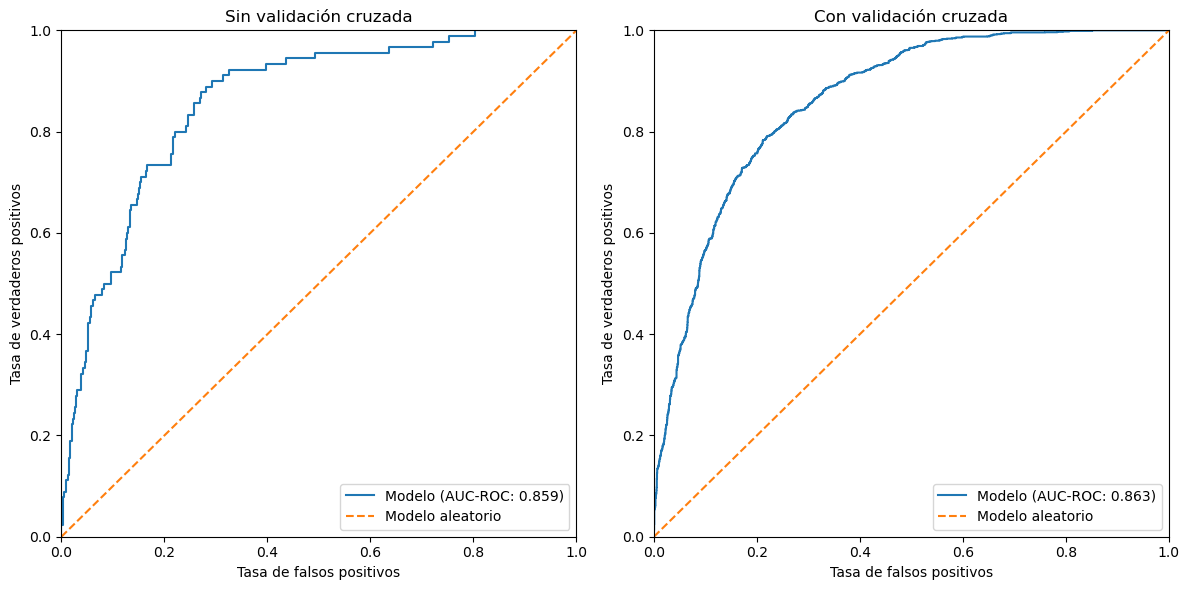

In [13]:
# Crear una figura con una fila y dos columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Sin validación cruzada
axes[0].plot(fpr, tpr, label=f'Modelo (AUC-ROC: {auc_roc_lr_sin_cv:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('Tasa de falsos positivos')
axes[0].set_ylabel('Tasa de verdaderos positivos')
axes[0].set_title('Sin validación cruzada')
axes[0].legend()

# Gráfico 2: Con validación cruzada
axes[1].plot(fpr_cv, tpr_cv, label=f'Modelo (AUC-ROC: {auc_roc_lr_cv:.3f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('Tasa de falsos positivos')
axes[1].set_ylabel('Tasa de verdaderos positivos')
axes[1].set_title('Con validación cruzada')
axes[1].legend()

# Ajustar espacio entre subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Bosque aleatorio de clasificación

#### Sin validación cruzada

In [ ]:
# Creación del modelo de Bosque Aleatorio simple
rfc = RandomForestClassifier(random_state=54321)
rfc.fit(features_train_ord, target_train_ord)

# Obtener las probabilidades predichas para la clase positiva
rfc_probabilities = rfc.predict_proba(features_valid_ord)[:, 1]

In [ ]:
# Calcular la curva ROC
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_valid_ord, rfc_probabilities)

# Calcular el AUC-ROC
auc_score = roc_auc_score(target_valid_ord, rfc_probabilities)
print('El AUC-ROC score fue de :', auc_score)

In [ ]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='blue',
         label=f'Bosque Aleatorio (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red',
         linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Bosque Aleatorio')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Con validación cruzada

In [ ]:
# Configurar el modelo de bosque aleatorio
rfc = RandomForestClassifier(random_state=54321)

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# Obtener predicciones probabilísticas usando validación cruzada
rfc_probabilities = cross_val_predict(
    rfc,
    features_train_ord,
    target_train_ord,
    cv=cv,
    method='predict_proba'
)

# Extraer probabilidades de la clase positiva
rfc_probabilities_one = rfc_probabilities[:, 1]

# Calcular el AUC-ROC para la validación cruzada
auc_score = roc_auc_score(target_train_ord, rfc_probabilities_one)
print('El AUC-ROC Score para un bosque aleatorio con validación cruzada es:', auc_score)

In [ ]:
# Calcular la curva ROC
fpr_rfc_cv, tpr_rfc_cv, thresholds = roc_curve(
    target_train_ord, rfc_probabilities_one)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc_cv, tpr_rfc_cv, color='blue',
         label=f'Bosque Aleatorio (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red',
         linestyle='--', label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Bosque Aleatorio con Validación Cruzada')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Optimización de hiperparámetros

#### GridSearchCV

In [ ]:
# Definir hiperparámetros a tunear
forest_params = [
    {'max_depth': list(range(1, 10)),
     'n_estimators': list(range(1, 50)),
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]}
]

In [ ]:
# Configurar GridSearchCV con la métrica de evaluación AUC-ROC
clf = GridSearchCV(
    rfc,
    forest_params,
    cv=9,
    scoring='roc_auc',
    error_score='raise'
)

# Entrenar el modelo con GridSearchCV
clf.fit(features_train_ord, target_train_ord)

print(f"Mejor valor para max_depth: {clf.best_params_['max_depth']}")
print(f"Mejor valor para n_estimators: {clf.best_params_['n_estimators']}")
print(f"Mejor estimador: {clf.best_estimator_}")
print(f"Mejor puntuación: {clf.best_score_}")

#### Optuna

In [ ]:

class ModelOptimization:
    '''
    Creación de clase para tunear hiperparámetros utilizando Optuna
    '''

    def __init__(self, features_train, features_valid, target_train, target_valid):
        self.features_train = features_train
        self.features_valid = features_valid
        self.target_train = target_train
        self.target_valid = target_valid

    def objective(self, trial):
        # Definir los hiperparámetros a optimizar
        max_depth = trial.suggest_int('max_depth', 1, 10)
        n_estimators = trial.suggest_int('n_estimators', 1, 50)

        # Crear el modelo con los hiperparámetros sugeridos
        model = RandomForestClassifier(
            max_depth=max_depth, n_estimators=n_estimators, random_state=54321)

        # Entrenar el modelo
        model.fit(self.features_train, self.target_train)

        # Predecir probabilidades en el conjunto de validación
        predictions_valid_proba = model.predict_proba(
            self.features_valid)[:, 1]

        # Calcular el AUC-ROC
        auc_score = roc_auc_score(self.target_valid, predictions_valid_proba)

        return auc_score

In [ ]:
# Para ejecutar Optuna
def optimize_model(features_train, features_valid, target_train, target_valid, n_trials=50):
    optimizer = ModelOptimization(
        features_train, features_valid, target_train, target_valid)
    study = optuna.create_study(direction='maximize')  # Maximizar el AUC-ROC
    study.optimize(optimizer.objective, n_trials=n_trials)

    print(f"Mejores parámetros: {study.best_params}")
    print(f"Mejor AUC-ROC Score: {study.best_value:.4f}")

    return study  # Retornar el objeto study

In [ ]:
# Ejecutar la optimización
study = optimize_model(features_train, features_valid,
                       target_train, target_valid, n_trials=2000)

In [ ]:
# Graficar el historial de optimización

vis.plot_optimization_history(study).show()

#### Potenciación de gradiente

In [ ]:
# Crear el modelo de CatBoost
model_cat = CatBoostClassifier(
    learning_rate=0.02,
    depth=7,
    random_seed=54321,
    iterations=2000,
    loss_function='Logloss',  # Pérdida adecuada para clasificación binaria
    eval_metric='AUC',        # Métrica de evaluación correcta
    verbose=100
)

In [ ]:
# Entrenar el modelo
model_cat.fit(features_train_ord, target_train_ord, cat_features=None)

# Obtener probabilidades sobre el conjunto de validación
preds_proba = model_cat.predict_proba(features_valid_ord)[:, 1]

# Calcular AUC-ROC
auc_score = roc_auc_score(target_valid_ord, preds_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")

#### CatBoost y Optuna

In [ ]:
# Definir el número de iteraciones para early stopping
early_stopping_rounds = 50  # Número de iteraciones consecutivas sin mejora permitidas


def optuna_catboost(trial):
    # Definir los hiperparámetros que Optuna optimizará
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.02, step=0.001),
        'depth': trial.suggest_int('depth', 7, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5),
        'grow_policy': 'Depthwise',
        'iterations': 4000,
        'use_best_model': True,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'od_type': 'Iter',
        'od_wait': early_stopping_rounds,
        'random_state': 54321,
        'logging_level': 'Silent'
    }

    # Inicializar el modelo de clasificación con los hiperparámetros definidos
    cat_classifier = CatBoostClassifier(**param)

    # Configurar la validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=54321)

    auc_scores = []

# Iterar sobre cada fold de la validación cruzada
    for train_idx, valid_idx in cv.split(features_train_ord, target_train_ord):
        X_train, X_valid = features_train_ord.iloc[train_idx], features_train_ord.iloc[valid_idx]
        y_train, y_valid = target_train_ord.iloc[train_idx], target_train_ord.iloc[valid_idx]

        # Entrenar el modelo con early stopping
        cat_classifier.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=early_stopping_rounds,
            verbose=False  # Silenciar la salida durante el entrenamiento
        )

        # Predecir probabilidades en el conjunto de validación
        preds_proba = cat_classifier.predict_proba(X_valid)[:, 1]

        # Calcular el AUC-ROC para el fold actual
        auc = roc_auc_score(y_valid, preds_proba)
        auc_scores.append(auc)

    # Calcular el promedio del AUC-ROC a través de todos los folds
    mean_auc = np.mean(auc_scores)

    return mean_auc

In [ ]:
# Configurar y ejecutar el estudio de Optuna
study = optuna.create_study(
    direction='maximize', sampler=optuna.samplers.TPESampler(seed=54321))
# Puedes ajustar n_trials y timeout según tus necesidades
study.optimize(optuna_catboost, n_trials=100, timeout=600)

# Obtener los mejores hiperparámetros
best_params = study.best_params
best_auc = study.best_value

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor AUC-ROC promedio: {best_auc:.4f}")